In [86]:
import os

import geopandas.datasets
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as geopd
import sklearn.cluster as clustering
import scipy.stats as stats
import numpy as np
os.chdir("/Users/simonedigregorio/Downloads/archive")

In [2]:
# Read the datasets
# Also converting the column cts in posters to date/time type. This will be useful for later stages
posts = pd.read_csv("instagram_posts.csv", delimiter="\t", parse_dates=[5], infer_datetime_format = True)
profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")
locations = pd.read_csv("instagram_locations.csv", delimiter="\t")

In [ ]:
# RQ1 - Basic EDA [H1]
# Let's start with a *very* basic summary of the features of the datasets. On a very coarse level of analysis, we can check the number of observations in each dataset. _Posts is definitely the bigger one (challenging especially for our memory), with 42'710'197 observations, followed by _profiles_ (with 4'509'586 observations) and _locations_ (with 1'022'658 observations).
# This makes sense considering that for every profile there will be n posts and considering that locations get repeated a lot among posts, with many posts not even having any location. Specifically, to prove the point, locations repeat on average 17 times in the _post_ dataset and there are 12'972'772 posts without locations as can be seen in the code (this partially answers a point of RQ2). Also, there are some inconsistencies in the datasets (posts from profiles not present in the _profile_ dataset or posts with tagged locations not present in the _locations_ dataset), so what we are saying here is approximate at best.

# Number of observations for dataset
print(f"Number of obs posts:{len(posts)}")
print(f"Number of obs profiles: {len(profiles)}")
print(f"Number of obs locations: {len(locations)}")

# Number of non-complete observations for dataset
# Is null returns a dataframe of booleans (na or not for each entry). Any returns true for each row (axis=1) which has a true value (a na field) and sums over the booleans, considering False as 0 and True as 1. This is a solution which is more elegant with respect to others.
print(f"Number of non-complete rows in posts: {posts.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in profiles: {profiles.isnull().any(axis=1).sum()}")
print(f"Number of non-complete rows in locations: {locations.isnull().any(axis=1).sum()}")

# Number of posts without locations
print("Number of posts without locations: {}".format(posts["location_id"].isnull().sum()))
# Mean number of posts for each location (2 decimal digits)
print("Mean number of repetitions for each location: {}".format(round(posts["location_id"].value_counts().mean())))

In [ ]:
# Features of the post dataset [H2]
# First step in any proper EDA is looking at the columns of the tables that we are using. Luckily the guy who uploaded the dataset on Kaggle was also very clear in describing the features. Let's start with the _posts_ dataset, the first and most important one:
# - The _sid_profile_ feature acts as something similar to a foreign key to link the _posts_ dataset to the _profiles_ dataset, allowing joins. -1 is the id for profiles not present in the _profiles_ dataset.
# - The post_id is the ID of the post itself, nothing particularly important to say: it is just a key of the table.
# - The _profile_id_ is the instagram ID of the profile which published the post.
# - The _location_id_ is the foreign key that links the _posts_ dataset to the _location_ one.
# - _cts_ is the timestamp of the post.
# - _post_type_ is a categorical variable (1, 2, 3) which tells us if the post was a photo, a video or multimedia.
# - _numbr_likes_ is the number of likes.
# - _number_comments_ is the number of comments.

print(posts.columns.values)

In [ ]:
# The only numerical variables for the _posts_ dataset are the number of likes, the number of comments. We print the basic summary statistics (mean, standard deviation, maximum, minimum and quartiles) for these variables in markdown format in order to put them into the notebook. From the table, we can already notice some important features of the distribution. For example, the variances are **very** high and the quartiles are all lower than the mean values. This specific last information tells us that the distribution is strongly right-tailed.
# More specifically, we can check that numerically (and statistically) by computing the skewness and the kurtosis (third and four standardized moment of the sample distribution).
# The skewness is in both cases **strongly** positive (very strong right tail indeed), which tells us that the mass is concentrated on the far left of the distro. This would be enough, but in order to make it more clear notice also the excess kurtosis (w.r.t. to the normal).
# These are extremely distorted distributions (the one for comments far more distorted than the one for likes), which makes sense since in a social network environment we expect the directed graph of connections/interactions to follow some kind of preferential attachment process.

# Print the basic summary statistics for the numeric variables
print(posts.describe().iloc[1:, 5:].to_markdown(), end = "\n\n")

# Print the skewness and the kurtosis for likes and comments
print("Skewness for likes distro: {}\nSkewness for comments distro: {}".format(round(posts["numbr_likes"].skew(), 2), round(posts["number_comments"].skew(), 2)))
print("Excess kurtosis for likes distro: {}\nExcess kurtosis for comments distro: {}".format(round(posts["numbr_likes"].kurtosis(), 2), round(posts["number_comments"].kurtosis(), 2)))

In [ ]:
# A way to visualize distributions so distorted would be to simply avoid considering the outliers and concentrate on the quartiles of the distribution. This can be done by plotting the boxplots considering just the quartiles and the whiskers (the right whisker is the 3rd quartile + 1.5 IQR) and avoiding the outliers. Showfliers = False in the Pandas utility method (which in turn calls matplotlib) is enough to make the plot readable. As can be seen in the table, look at how low is the value of the points in the interquartile range.

# Boxplot numerical of posts
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
posts["numbr_likes"].plot.box(showfliers=False, vert=False, ax=ax, fontsize = "large")
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Boxplot for # of likes per post", {"fontsize":18})
ax = plt.subplot(1, 2, 2)
posts["number_comments"].plot.box(showfliers=False, vert=False, ax=ax, fontsize = "large")
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Boxplot for # of comments per post", {"fontsize":18})
plt.suptitle("Boxplots for the numerical features of the posts dataset", fontsize = 40)
plt.tight_layout(pad = 2)
plt.show()

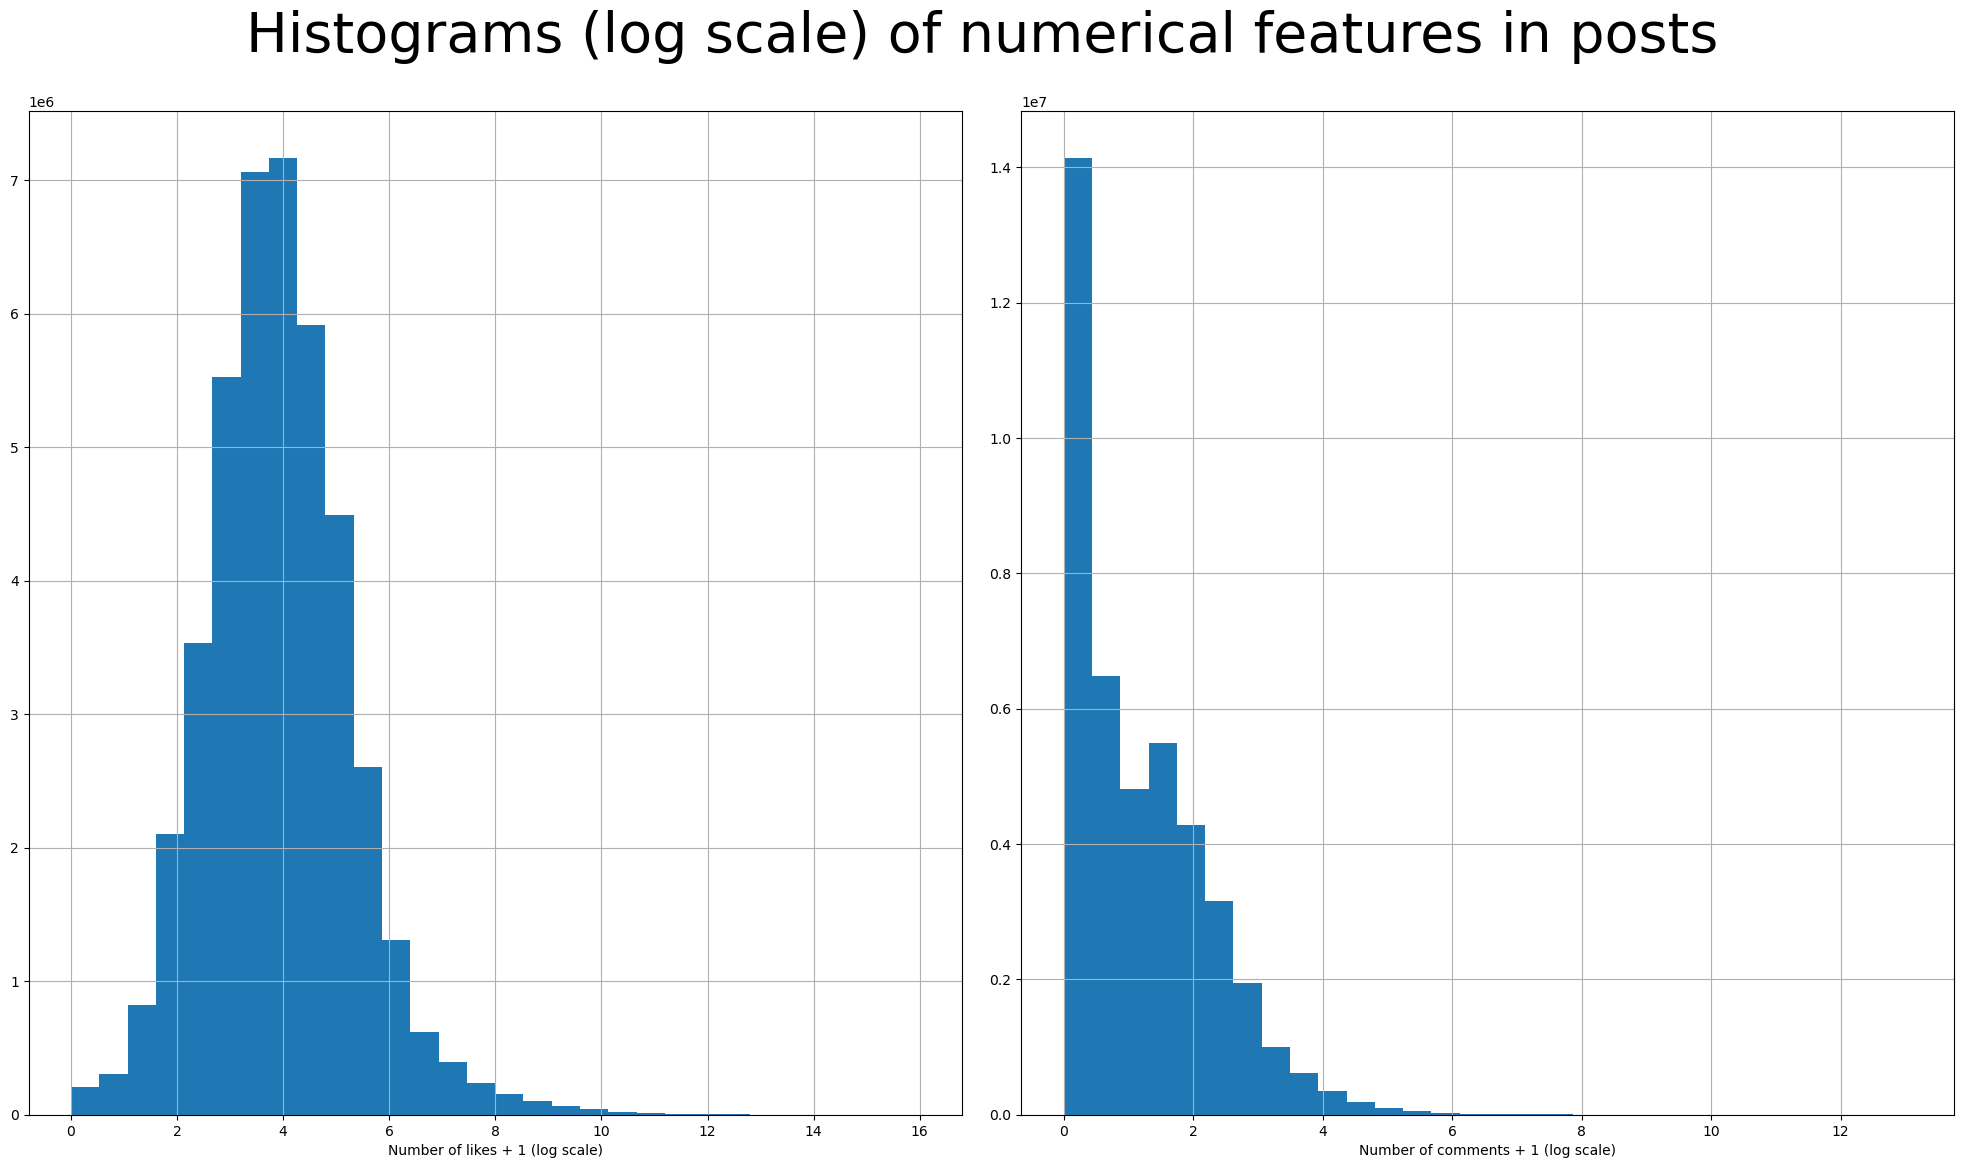

In [124]:
# Another way would be to plot the histogram frequencies on a logarithmic scale. (Another idea I had by talking with a colleague). +1 was inserted to avoid the problem due to the logarithm not defined in 0.

plt.figure(figsize=(20, 12))
ax = plt.subplot(1, 2, 1)
(posts["numbr_likes"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of likes + 1 (log scale)")
ax = plt.subplot(1, 2, 2)
(posts["number_comments"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of comments + 1 (log scale)")
plt.suptitle("Histograms (log scale) of numerical features in posts", fontsize = 40)
plt.tight_layout(pad = 2)
plt.show()

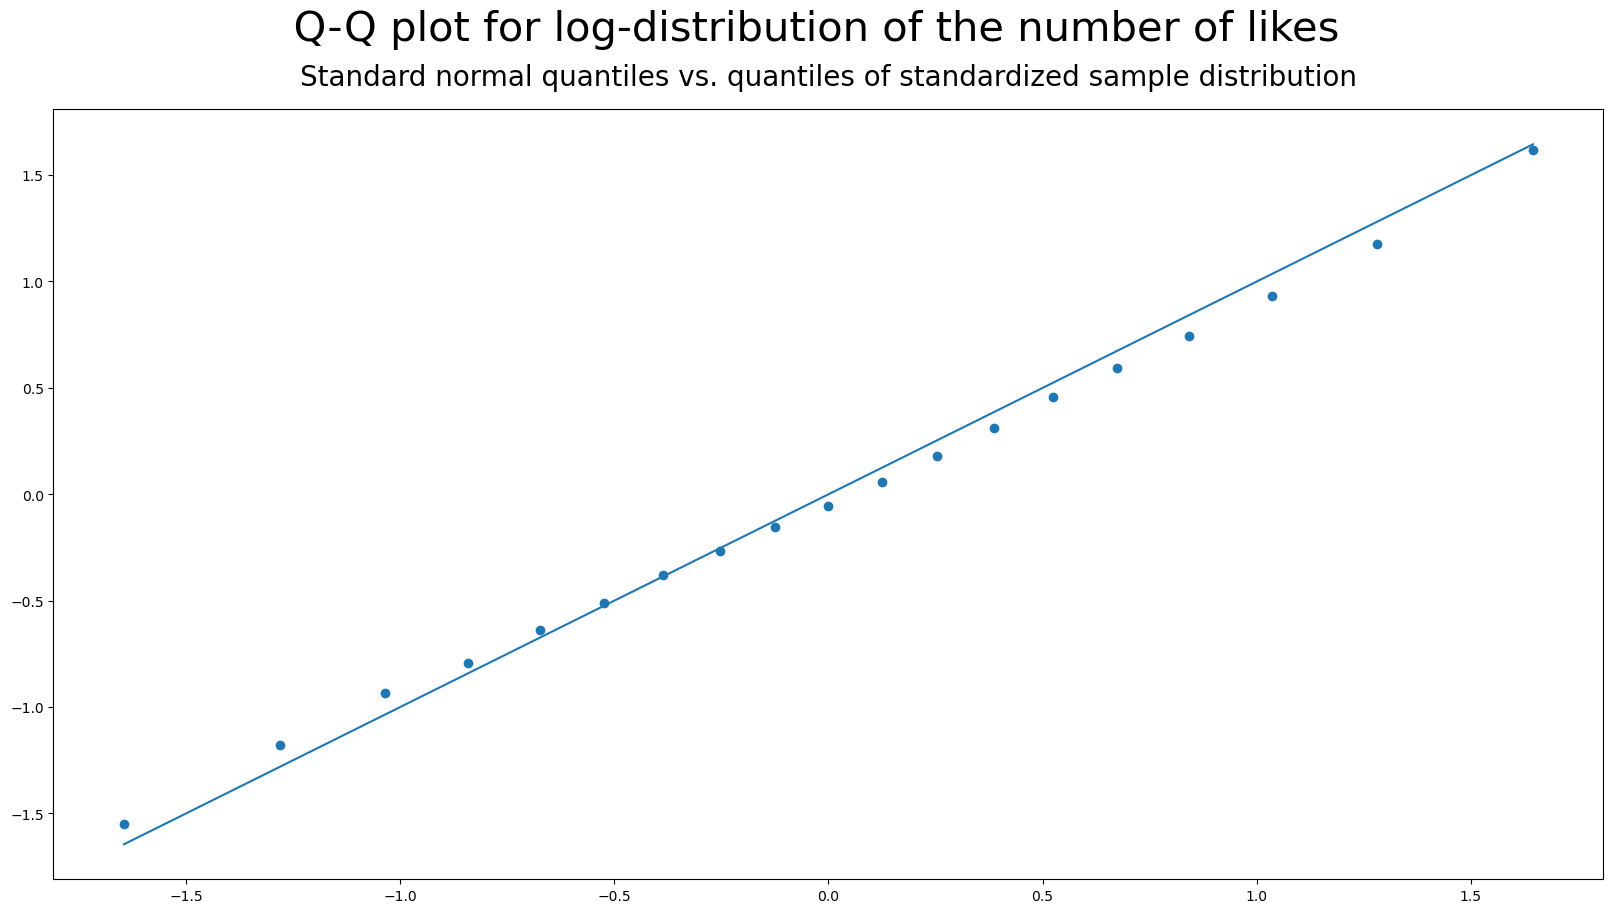

In [125]:
# It seems that the distribution of likes is approximately log-normal, i.e. the logarithm of the number of likes is normally distributed. A way to test this would be a quantile-quantile plot. Let's plot that.
# From the plot, we can see that it definitely seems log-normal. The quantiles of the (standardized) sample distribution of the log number of likes almost perfectly match with the ones of a standard normal.

quantiles_stdnorm = [stats.norm.ppf(x) for x in np.arange(0.05, 0.96, 0.05)]

log_transformed_likes = (posts["numbr_likes"]+1).apply(np.log)
sample_quantiles_likes = ((log_transformed_likes-log_transformed_likes.mean())/log_transformed_likes.std()).quantile(np.arange(0.05, 0.96, 0.05))


plt.figure(figsize=(20, 10))
plt.suptitle("  Q-Q plot for log-distribution of the number of likes", fontsize = 30)
plt.title("Standard normal quantiles vs. quantiles of standardized sample distribution", fontsize = 20, y = 1.02)
ax = plt.gca()
ax.plot(quantiles_stdnorm, quantiles_stdnorm)
ax.scatter(quantiles_stdnorm, sample_quantiles_likes)
plt.show()

In [ ]:
# At this point, in this preliminary EDA, a cool stuff that we can do is plotting the mean number of posts per weekday. We can do that quite easily by counting the observations using the weekday as grouping key and then normalizing the count with the number of weeks in the dataset.
# As one could expect, the weekend sees the number of posts skyrocketing (less working hours, more trips/holidays, stronger presence of the users online).
plt.figure(figsize = (12, 8))
number_of_weeks = len(posts["cts"].dt.isocalendar().iloc[:, 0:2].drop_duplicates())
grouped_dayweek_post = posts.groupby(posts["cts"].dt.dayofweek)
week_list = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
count_week = grouped_dayweek_post["sid"].count().set_axis(week_list)
# This normalizes the number of posts giving us the mean number post for each day (across the years)
count_week /= number_of_weeks
count_week.plot(marker="o")
plt.xlabel("Day of week")
plt.ylabel("# of posts")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Features of the profile dataset [H2]
# Again, as we did before, let's recap the columns in the DataFrame:
# - _sid_ is the key which is used as reference for the foreign key in _posts_
# - profile_id is another id (the Instagram one).
# - profile_name nomen omen.
# - _firstname_lastname_ nomen omen.
# - _description_ is the description of the profile. Looking at the actual strings, it is the "bio" of the profile.
# - _following_ is the number of accounts followed by the users.
# - _followers_ is the number of accounts which follow the user.
# - _n_posts_ is the number of posts published by the user.
# - _url_ is the URL highlighted in the profile under the description/bio.
# - _cts_ is the timestamp for the time when the data of the profile was scraped.
# - _is_business_account_ is a boolean to check if the profile is a business account or not.

print(profiles.columns.values)

In [ ]:
# The only numerical columns here are _following_, _followers_ and n_posts. Let's look at their distribution by printing summary statistics and drawing some boxplots. Especially for what concerns the followers, what we see is basically the quintessence of what we explained in the previous section of this question.
# However, since RQ8 specifically deals with the followers' distribution, we will not go in depth with that now.

# Without looking at the absolute values of skewness and kurtosis, we can understand what we are seeing by looking at the ratios printed below. The skewness of the sample distributions of the number of followers is 3.46 times the one of the number of likes in the _posts_ dataset, while the kurtosis is 7.21 times larger. Therefore, the distribution of the number of followers is even more distorted than the one for likes, even though the overall shape is anyway similar: a very strong tail to the right and the mass thus concentrated to the left.
# Again, this is due to preferential attachment processes underlying social networks dynamics, which is even more intuitive, natural and clear when we think about the way profiles cluster in the directed social graph when looking at the edges represented by the follower connections. Intuitively, a new user is far more likely to follow a small set of users (VIPs) which have an already high number of followers, and this is basically the informal definition of a preferential attachment process.

# Let's jump to the number of posts for now. The distribution for the number of posts seems far less distorted than the one of followers, and this is because the number of posts is not something **strictly** related to the popularity of the user, which is in turn modelled by a preferential attachment process. Again, this is intuitive: a user may enjoy interacting with its relatively small subset of followers and publish a lot, maybe at the same or at a similar rate of an influencer.
# The distortion (anyway present) highlighted by skewness and kurtosis can be easily explained (at least in part) by the fact that a social network is full of zombie accounts: bots, inactive users and people subscribing just to follow other people.

# Basic summary statistics for profiles
print(profiles.describe().iloc[1:, 2:].drop("min", axis = 0).to_markdown(), end = "\n\n")

print("Skewness for # of posts distro: {}".format(round(profiles["n_posts"].skew(), 2)))
print("Excess kurtosis for # of posts distro: {}".format(round(profiles["n_posts"].kurtosis(), 2)))

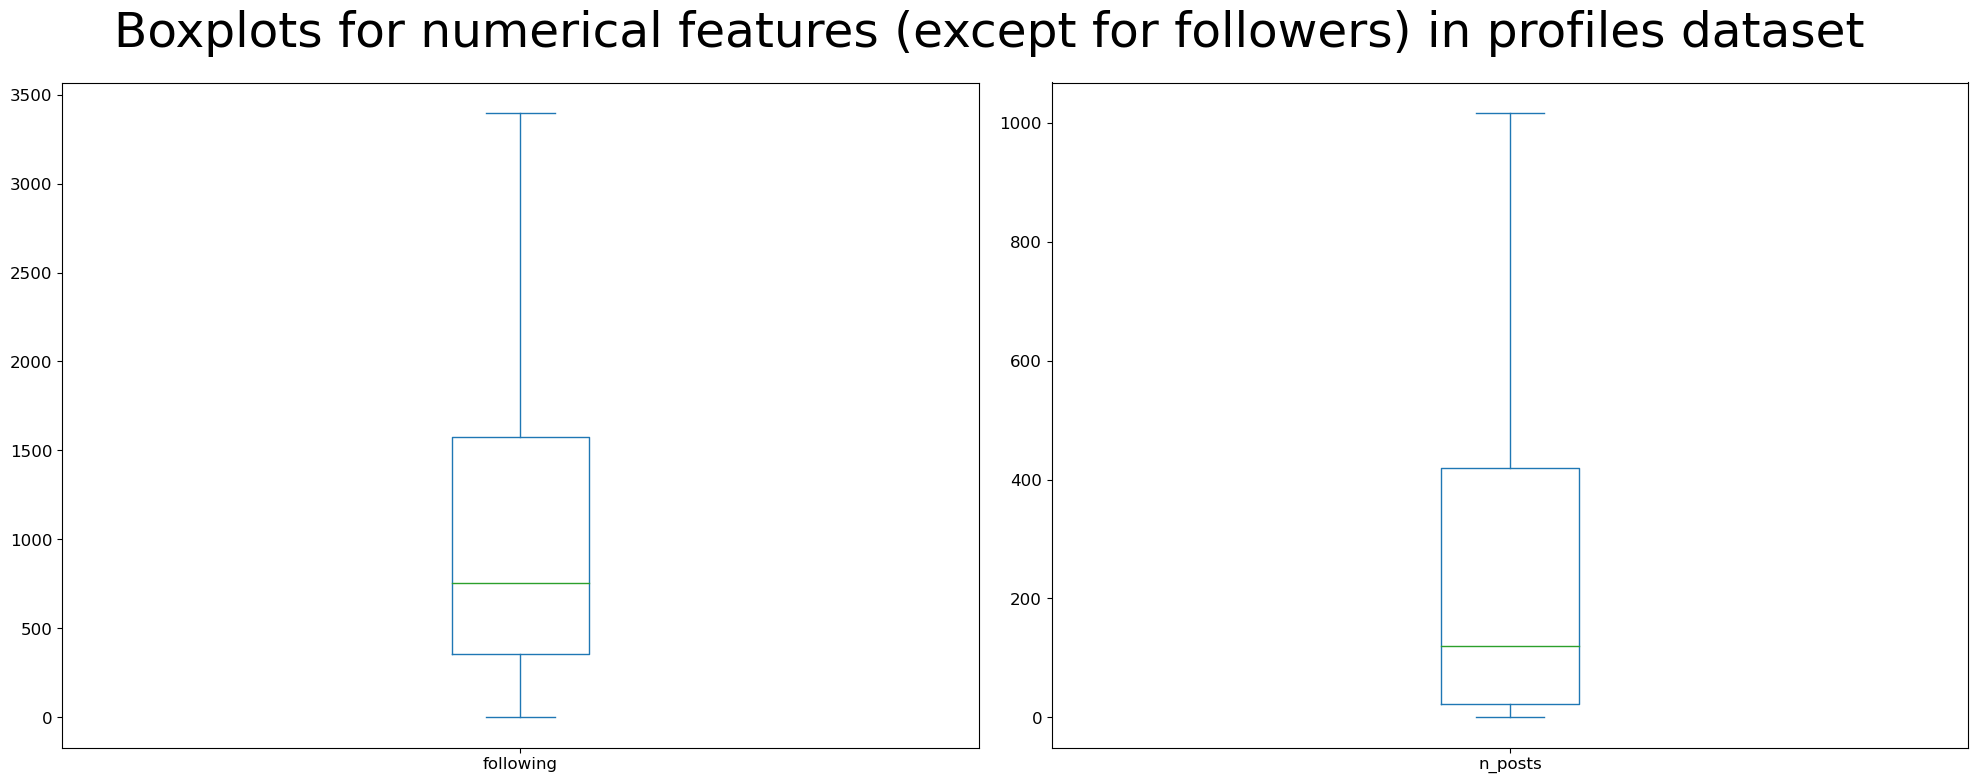

In [106]:
# Boxplots of numerical features in profiles
plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
profiles[["following"]].plot.box(showfliers=False, fontsize = "large", ax = ax)
ax = plt.subplot(1, 2, 2)
profiles[["n_posts"]].plot.box(showfliers=False, fontsize = "large", ax = ax)
plt.suptitle("Boxplots for numerical features (except for followers) in profiles dataset", fontsize = 35)
plt.tight_layout(pad = 1.5)
plt.show()

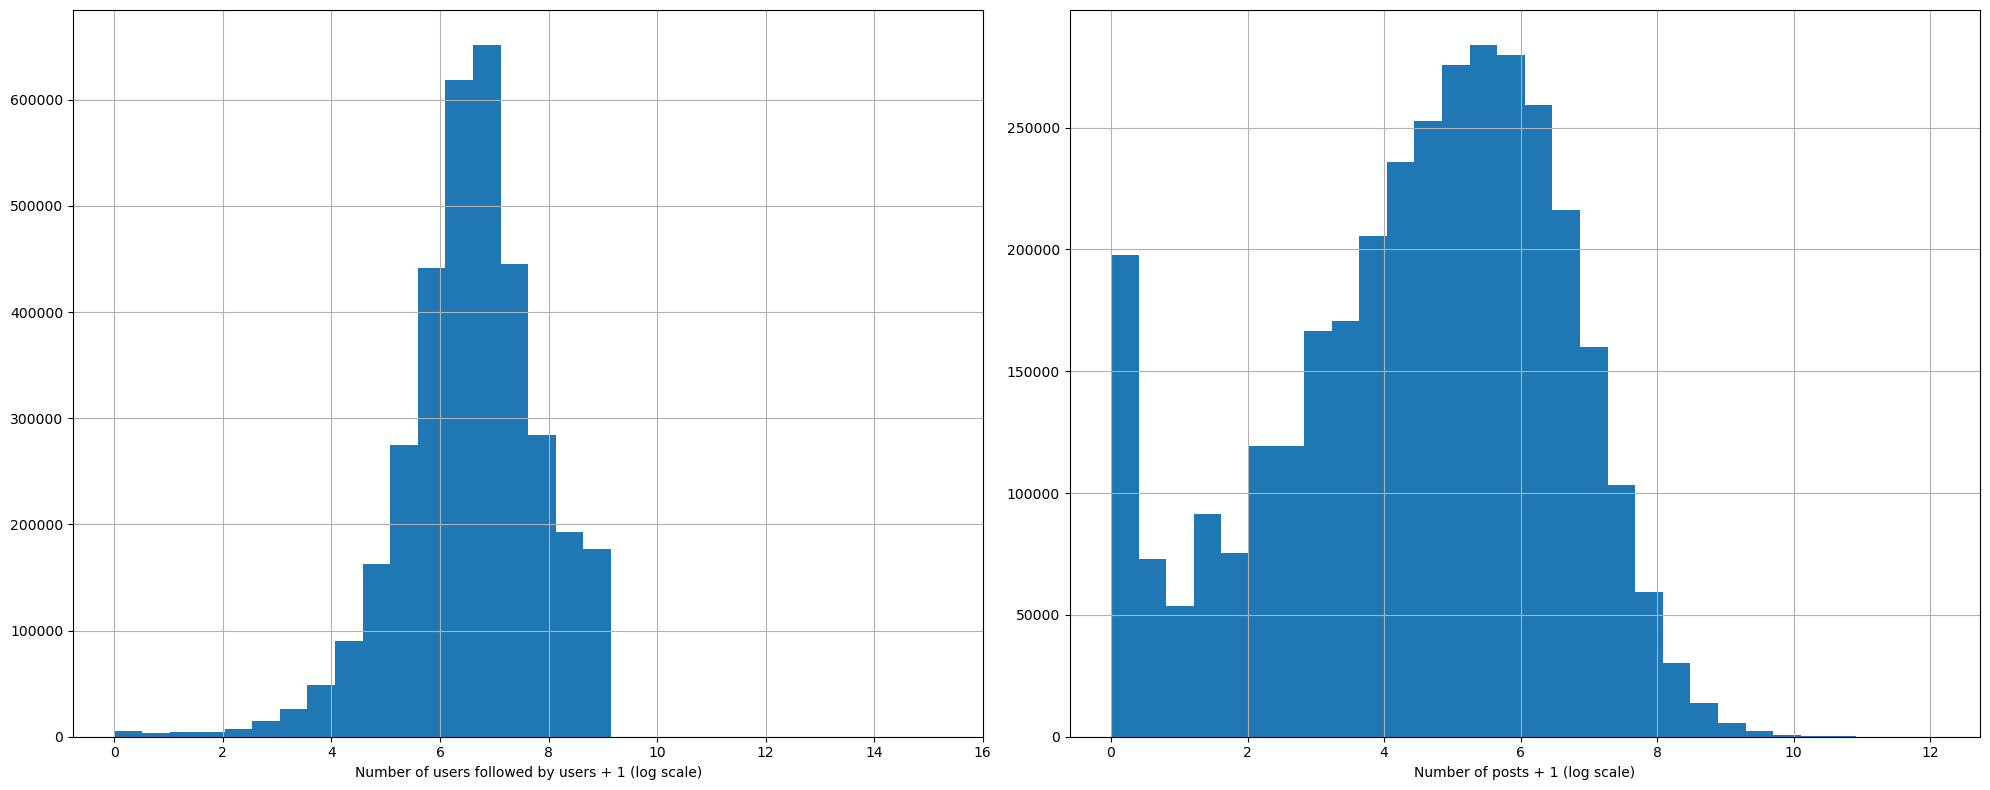

In [127]:
# ADD HISTOGRAMS ON LOG SCALE

plt.figure(figsize=(20, 8))
ax = plt.subplot(1, 2, 1)
(profiles["following"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of users followed by users + 1 (log scale)")
ax = plt.subplot(1, 2, 2)
(profiles["n_posts"]+1).apply(np.log).hist(ax = ax, bins = 30)
ax.set_xlabel("Number of posts + 1 (log scale)")
plt.tight_layout()
plt.show()

In [ ]:
# Features of the location dataset [H2]
# Description of the features
# ...
print(locations.columns.values)
print(f"Missing coordinates (percentage): {round(locations.lng.isna().sum()/len(locations), 5)}")
assert locations.lng.isna().sum() == locations.lat.isna().sum()

In [116]:
# The only meaningful thing that we can do with this dataset is plotting the locations on a world map

# Swap latitude and longitude: in the dataset they are one in the place of the other
locations["lat"], locations["lng"] = locations["lng"], locations["lat"]

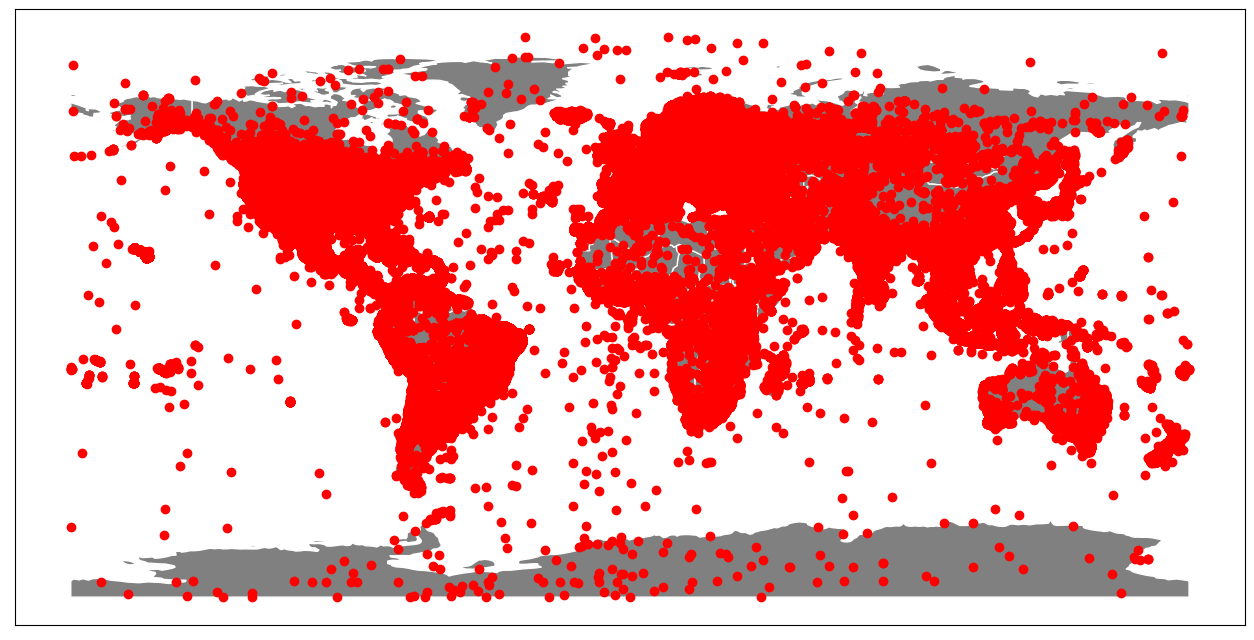

In [117]:
plt.figure(figsize=(17, 8))
ax = plt.gca()
world = geopd.read_file(geopd.datasets.get_path("naturalearth_lowres"))
world.plot(color="gray", edgecolor = "white", ax = ax)
plt.sca(ax)
plt.scatter(locations["lng"], locations["lat"], color = "red")
plt.xticks([])
plt.yticks([])
plt.show()
# This is a clear case of overplotting

In [121]:
# How can we solve this? The simplest and probably the most effective way would be to cluster the data
# K-means clustering with scikit
kmeans_fit = clustering.KMeans(n_clusters=100, verbose=2, n_init=10, random_state=123, max_iter=50, tol = 0).fit(locations[["lng", "lat"]].dropna())

Initialization complete
Iteration 0, inertia 11003901.783726411.
Iteration 1, inertia 8917682.108431336.
Iteration 2, inertia 8776937.185718285.
Iteration 3, inertia 8671105.417743228.
Iteration 4, inertia 8618341.230163962.
Iteration 5, inertia 8612853.1619394.
Iteration 6, inertia 8608475.972197073.
Iteration 7, inertia 8606586.44240665.
Iteration 8, inertia 8605367.63296544.
Iteration 9, inertia 8603887.689464005.
Iteration 10, inertia 8595653.536887713.
Iteration 11, inertia 8583442.715951132.
Iteration 12, inertia 8563619.484082073.
Iteration 13, inertia 8550390.018158412.
Iteration 14, inertia 8536251.485290349.
Iteration 15, inertia 8531536.510173097.
Iteration 16, inertia 8527457.774674788.
Iteration 17, inertia 8526385.28055454.
Iteration 18, inertia 8526259.342720237.
Iteration 19, inertia 8526233.902289636.
Iteration 20, inertia 8526226.261654556.
Iteration 21, inertia 8526221.868487097.
Iteration 22, inertia 8526217.96364384.
Iteration 23, inertia 8526214.210664874.
Iterati

In [122]:
# Get centroids, get number of observations for each cluster (will be used as size of the point)
centroids = kmeans_fit.cluster_centers_
_ , weights = np.unique(kmeans_fit.labels_, return_counts=True)
geocluster_df = pd.DataFrame(centroids, columns = [["lng", "lat"]])
standardization_factor_positions = np.std(weights)
geocluster_df["weights"] = weights/standardization_factor_positions*50

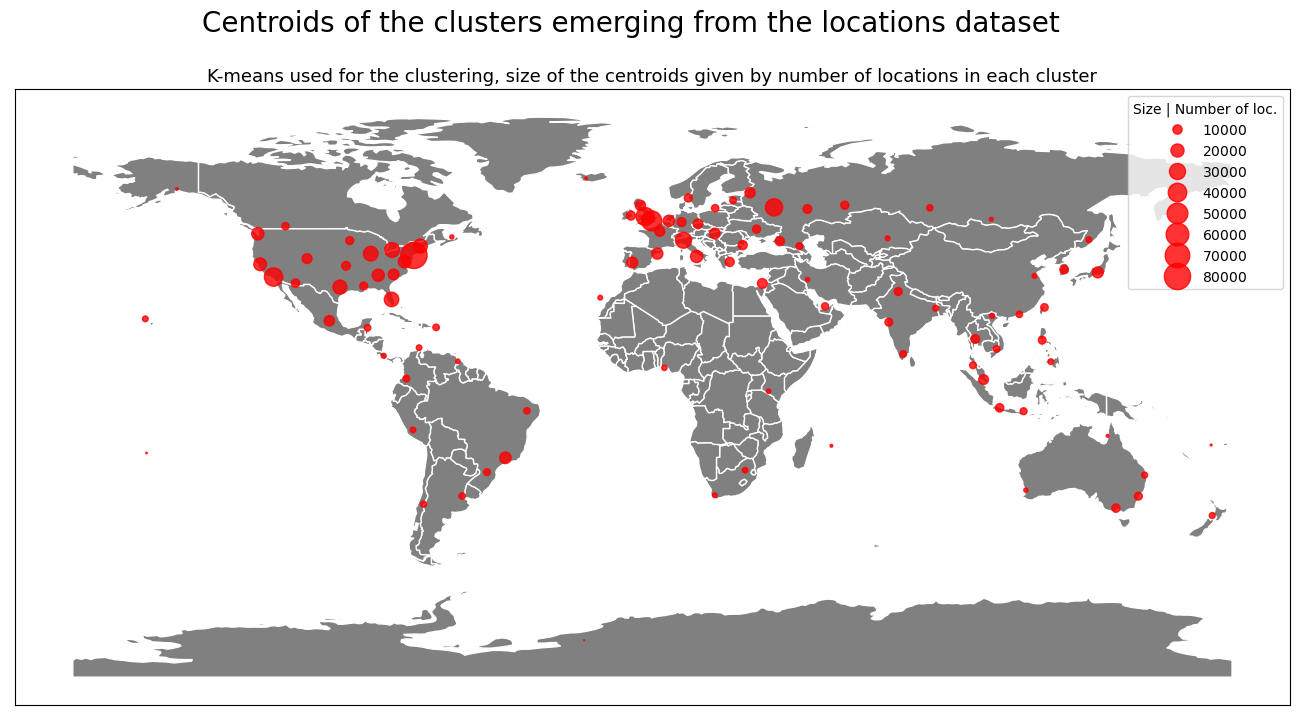

In [123]:
plt.figure(figsize=(17, 8))
ax = plt.gca()
world.plot(color="gray", edgecolor = "white", ax = ax)
plt.sca(ax)
scatter_plot = plt.scatter(geocluster_df.iloc[:, 0], geocluster_df.iloc[:, 1], color = "red", alpha = 0.8, s = geocluster_df["weights"])
plt.xticks([])
plt.yticks([])

handles, labels = scatter_plot.legend_elements(prop="sizes", alpha=0.8, color="red", func = lambda x: x*standardization_factor_positions/50)

plt.legend(handles, labels, title = "Size | Number of loc.")
plt.suptitle("Centroids of the clusters emerging from the locations dataset", fontsize = 20)
plt.title("K-means used for the clustering, size of the centroids given by number of locations in each cluster", fontsize = 13)
plt.show()